In [1]:
import sys
sys.path.append("..")

from src.utils.pgsql import pg_df
import pandas as pd
import numpy as np
import json

pd.set_option('display.max_columns', None)

In [2]:
# Scoring rules
## missing -> pick-6, 40+ yard completions, 50+ yard passing tds
## missing -> 40+ yard rush, 50+ yard rushing tds
## missing -> 40+ yard receptions, 50+ yard receiving tds
## missing -> defensive stats, kicking stats
with open("scoring_dict.json", "r") as fp:
    scoring_dict = json.load(fp)
scoring_dict

{'interceptions': -2.0,
 'pass_2pt': 2.0,
 'passing_tds': 6.0,
 'passing_first_downs': 0.25,
 'passing_2pt_conversions': 2.0,
 'rushing_yards': 0.1,
 'rushing_tds': 6.0,
 'rushing_2pt_conversions': 2.0,
 'rushing_first_downs': 0.5,
 'receptions': 0.5,
 'receiving_yards': 0.1,
 'receiving_tds': 6.0,
 'receiving_2pt_conversions': 2.0,
 'receiving_first_downs': 0.5,
 'rushing_fumbles': -1.0,
 'rushing_fumbles_lost': -1.0,
 'receiving_fumbles': -1.0,
 'receiving_fumbles_lost': -1.0,
 'sack_fumbles': -1.0,
 'sack_fumbles_lost': -1.0}

In [3]:
def calculate_fantasy_points(row, scoring_dict):
    points = 0
    
    # Passing stats with floor division
    passing_yards = row.get('passing_yards', 0)
    pass_yard_increment = scoring_dict.get('passing_yards', 0)
    if pass_yard_increment > 0:
        passing_yards = passing_yards - (passing_yards % int(1/pass_yard_increment))
    points += passing_yards * pass_yard_increment

    # Passing stats
    points += row.get('interceptions', 0) * scoring_dict.get('interceptions', 0)
    points += row.get('passing_tds', 0) * scoring_dict.get('passing_tds', 0)
    points += row.get('passing_first_downs', 0) * scoring_dict.get('passing_first_downs', 0)
    points += row.get('passing_2pt_conversions', 0) * scoring_dict.get('passing_2pt_conversions', 0)

    # Rushing stats with floor division
    rushing_yards = row.get('rushing_yards', 0)
    yard_increment = scoring_dict.get('rushing_yards', 0)
    if yard_increment > 0:
        rushing_yards = rushing_yards - (rushing_yards % int(1/yard_increment))
    points += rushing_yards * yard_increment
    
    points += row.get('rushing_tds', 0) * scoring_dict.get('rushing_tds', 0)
    points += row.get('rushing_2pt_conversions', 0) * scoring_dict.get('rushing_2pt_conversions', 0)
    points += row.get('rushing_first_downs', 0) * scoring_dict.get('rushing_first_downs', 0)
    points += row.get('rushing_fumbles', 0) * scoring_dict.get('rushing_fumbles', 0)
    points += row.get('rushing_fumbles_lost', 0) * scoring_dict.get('rushing_fumbles_lost', 0)
    
    # Receiving stats with floor division
    receiving_yards = row.get('receiving_yards', 0)
    rec_yard_increment = scoring_dict.get('receiving_yards', 0)
    if rec_yard_increment > 0:
        receiving_yards = receiving_yards - (receiving_yards % int(1/rec_yard_increment))
    points += receiving_yards * rec_yard_increment
    
    points += row.get('receptions', 0) * scoring_dict.get('receptions', 0)
    points += row.get('receiving_tds', 0) * scoring_dict.get('receiving_tds', 0)
    points += row.get('receiving_2pt_conversions', 0) * scoring_dict.get('receiving_2pt_conversions', 0)
    points += row.get('receiving_first_downs', 0) * scoring_dict.get('receiving_first_downs', 0)
    points += row.get('receiving_fumbles', 0) * scoring_dict.get('receiving_fumbles', 0)
    points += row.get('receiving_fumbles_lost', 0) * scoring_dict.get('receiving_fumbles_lost', 0)
    
    # Sack fumbles
    points += row.get('sack_fumbles', 0) * scoring_dict.get('sack_fumbles', 0)
    points += row.get('sack_fumbles_lost', 0) * scoring_dict.get('sack_fumbles_lost', 0)
    
    return points


In [ ]:
# analysing seasonal data looking at prior seasons correlation to the following season
weekly_df = pg_df("""
    SELECT * 
    FROM nfl_weekly_stats 
    WHERE season >= 1999
    AND season_type = 'REG'
    AND position IN ('QB', 'RB', 'WR', 'TE')
    """)


## analysing fantasy points
weekly_df['fantasy_points_milk_bone'] = weekly_df.apply(lambda row: calculate_fantasy_points(row, scoring_dict), axis=1)

In [5]:
weekly_df.head(2)

,player_id,season,week,player_name,player_display_name,position,position_group,recent_team_old,opponent_team,season_type,completions,attempts,passing_yards,passing_tds,interceptions,sacks,sack_yards,sack_fumbles,sack_fumbles_lost,passing_air_yards,passing_yards_after_catch,passing_first_downs,passing_epa,passing_2pt_conversions,carries,rushing_yards,rushing_tds,rushing_fumbles,rushing_fumbles_lost,rushing_first_downs,rushing_epa,rushing_2pt_conversions,targets,receptions,receiving_yards,receiving_tds,receiving_fumbles,receiving_fumbles_lost,receiving_air_yards,receiving_yards_after_catch,receiving_first_downs,receiving_epa,receiving_2pt_conversions,special_teams_tds,fantasy_points,fantasy_points_ppr,target_share,air_yards_share,wopr,created_at,updated_at,headshot_url,recent_team,pacr,racr,dakota,fantasy_points_milk_bone
0,00-0033045,2017,4,E.Elliott,Ezekiel Elliott,RB,RB,None,LA,REG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,85.0,1.0,0.0,0.0,6.0,0.941983,0.0,5.0,4.0,54.0,1.0,0.0,0.0,8.0,49.0,2.0,4.572967,0.0,0.0,25.9,29.9,0.142857,0.023055,0.230424,2025-08-10 23:22:50.888530,2025-08-10 23:22:50.888532,https://static.www.nfl.com/image/upload/f_auto...,DAL,0.0,6.75,0.0,31.0
1,00-0033045,2017,5,E.Elliott,Ezekiel Elliott,RB,RB,None,GB,REG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0,116.0,0.0,0.0,0.0,7.0,-1.456379,0.0,2.0,1.0,16.0,0.0,0.0,0.0,-5.0,21.0,0.0,-2.098134,0.0,0.0,13.2,14.2,0.055556,-0.018315,0.070513,2025-08-10 23:22:50.888533,2025-08-10 23:22:50.888535,https://static.www.nfl.com/image/upload/f_auto...,DAL,0.0,-3.20,0.0,16.0


In [6]:
## scoring check
# weekly_df[['fantasy_points', 
#            'fantasy_points_ppr', 
#            'fantasy_points_milk_bone', 
#            'passing_yards',
#            'passing_2pt_conversions',
#            'rushing_yards', 
#            'rushing_tds', 
#            'rushing_2pt_conversions', 
#            'rushing_first_downs', 
#            'rushing_fumbles', 
#            'rushing_fumbles_lost', 
#            'receiving_yards', 
#            'receptions',
#            'receiving_tds', 
#            'receiving_2pt_conversions', 
#            'receiving_first_downs', 
#            'receiving_fumbles', 
#            'receiving_fumbles_lost', 
#            'sack_fumbles', 
#            'sack_fumbles_lost']].head()

In [7]:
# create seasonal aggregation
season_cols = [
'player_id', 'season', 'player_display_name', 'position', 

       'fantasy_points_milk_bone',

       'completions', 'attempts', 
       'passing_yards','passing_tds', 'interceptions', 
       'passing_first_downs', 'passing_2pt_conversions',

       'carries', 'rushing_yards', 
       'rushing_tds', 'rushing_fumbles',
       'rushing_fumbles_lost', 'rushing_first_downs', 
       'rushing_2pt_conversions', 

       'targets', 'receptions', 
       'receiving_yards', 'receiving_tds', 
       'receiving_fumbles', 'receiving_fumbles_lost',
       'receiving_first_downs', 'receiving_2pt_conversions'

]

# weekly to seasonal aggregation
season_df = weekly_df[season_cols].groupby(['player_id', 'season', 'player_display_name', 'position']).agg('sum').reset_index()

In [8]:
# Create prior year fantasy points feature by player
season_df = season_df.sort_values(['player_id', 'season'])
season_df['prior_year_ff_points'] = season_df.groupby('player_id')['fantasy_points_milk_bone'].shift(1)

# Add additional lag features for analysis
season_df['prior_2_year_ff_points'] = season_df.groupby('player_id')['fantasy_points_milk_bone'].shift(2)
season_df['prior_3_year_ff_points'] = season_df.groupby('player_id')['fantasy_points_milk_bone'].shift(3)

# Create year-over-year change metrics
season_df['yoy_ff_change'] = season_df['fantasy_points_milk_bone'] - season_df['prior_year_ff_points']

# Handle infinite values in log calculation
# Only calculate log change where both current and prior year points > 0
mask = (season_df['fantasy_points_milk_bone'] > 0) & (season_df['prior_year_ff_points'] > 0)
season_df['yoy_ff_pct_change'] = np.where(
    mask,
    np.log(season_df['fantasy_points_milk_bone'] / season_df['prior_year_ff_points']),
    0
)

# Display results
season_df[['season', 'player_display_name', 'position', 'fantasy_points_milk_bone', 
           'prior_year_ff_points', 'yoy_ff_change', 'yoy_ff_pct_change']].head(10)

# Fill remaining NaN values with 0
season_df[['prior_year_ff_points', 'prior_2_year_ff_points', 'prior_3_year_ff_points', 'yoy_ff_change', 'yoy_ff_pct_change']] = season_df[['prior_year_ff_points', 'prior_2_year_ff_points', 'prior_3_year_ff_points', 'yoy_ff_change', 'yoy_ff_pct_change']].fillna(0)

c:\Users\Jason\ffb\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Jason\ffb\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
### Player
player = pg_df("""
    select 
        full_name, 
        position, 
        college, 
        height, 
        weight, 
        age, 
        years_exp
    from players
    where team is not Null
    and position in ('RB', 'WR', 'TE', 'QB')
""")

player.head()


,full_name,position,college,height,weight,age,years_exp
0,Le'Veon Bell,RB,Michigan State,73,225,29.0,9
1,Parker Washington,WR,Penn State,70,204,23.0,2
2,Salvon Ahmed,RB,Washington,71,197,26.0,5
3,CeeDee Lamb,WR,Oklahoma,74,200,26.0,5
4,Michael Gallup,WR,Colorado State,73,205,29.0,7


In [10]:
### Joining player_df to season_df
season_df = season_df.merge(player, left_on=['player_display_name', 'position'], right_on=['full_name', 'position'], how='left')

In [20]:
season_df.season.unique()

array([2005, 2006, 2007, 2009, 2010, 2011, 2012, 2008, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024])

In [11]:
# Create season_age feature based on player's most recent age
season_df['max_season'] = season_df.groupby('player_id')['season'].transform('max')
season_df['season_age'] = season_df['age'] - (season_df['max_season'] - season_df['season'])

# Clean up temporary column
#season_df = season_df.drop('max_season', axis=1)

# Verify the calculation
print("Season age calculation check:")
print(season_df[['player_display_name', 'season', 'max_season', 'age', 'season_age']].head(10))

Season age calculation check:
  player_display_name  season  max_season  age  season_age
0   Stephen Alexander    2005        2006  NaN         NaN
1   Stephen Alexander    2006        2006  NaN         NaN
2  Obafemi Ayanbadejo    2005        2006  NaN         NaN
3  Obafemi Ayanbadejo    2006        2006  NaN         NaN
4          Tony Banks    2005        2005  NaN         NaN
5         Tiki Barber    2005        2006  NaN         NaN
6         Tiki Barber    2006        2006  NaN         NaN
7       Charlie Batch    2005        2012  NaN         NaN
8       Charlie Batch    2006        2012  NaN         NaN
9       Charlie Batch    2007        2012  NaN         NaN


In [12]:
# Create season_years_exp feature based on player's most recent years_exp
season_df['season_years_exp'] = season_df['years_exp'] - (season_df['max_season'] - season_df['season'])

# Verify the calculation
print("Season years experience calculation check:")
print(season_df[['player_display_name', 'season', 'max_season', 'years_exp', 'season_years_exp']].head(10))

Season years experience calculation check:
  player_display_name  season  max_season  years_exp  season_years_exp
0   Stephen Alexander    2005        2006        NaN               NaN
1   Stephen Alexander    2006        2006        NaN               NaN
2  Obafemi Ayanbadejo    2005        2006        NaN               NaN
3  Obafemi Ayanbadejo    2006        2006        NaN               NaN
4          Tony Banks    2005        2005        NaN               NaN
5         Tiki Barber    2005        2006        NaN               NaN
6         Tiki Barber    2006        2006        NaN               NaN
7       Charlie Batch    2005        2012        NaN               NaN
8       Charlie Batch    2006        2012        NaN               NaN
9       Charlie Batch    2007        2012        NaN               NaN


In [13]:
season_df.loc[season_df.full_name == "Le'Veon Bell", ['full_name', 'season', 'age', 'season_age', 'years_exp', 'season_years_exp']]

,full_name,season,age,season_age,years_exp,season_years_exp
5638,Le'Veon Bell,2013,29.0,21.0,9.0,1.0
5639,Le'Veon Bell,2014,29.0,22.0,9.0,2.0
5640,Le'Veon Bell,2015,29.0,23.0,9.0,3.0
5641,Le'Veon Bell,2016,29.0,24.0,9.0,4.0
5642,Le'Veon Bell,2017,29.0,25.0,9.0,5.0
5643,Le'Veon Bell,2019,29.0,27.0,9.0,7.0
5644,Le'Veon Bell,2020,29.0,28.0,9.0,8.0
5645,Le'Veon Bell,2021,29.0,29.0,9.0,9.0


In [18]:
### RB position
rb_df = season_df[season_df['position'] == 'RB']
print(rb_df.shape)
rb_df.head()

(2599, 41)


,player_id,season,player_display_name,position,fantasy_points_milk_bone,completions,attempts,passing_yards,passing_tds,interceptions,passing_first_downs,passing_2pt_conversions,carries,rushing_yards,rushing_tds,rushing_fumbles,rushing_fumbles_lost,rushing_first_downs,rushing_2pt_conversions,targets,receptions,receiving_yards,receiving_tds,receiving_fumbles,receiving_fumbles_lost,receiving_first_downs,receiving_2pt_conversions,prior_year_ff_points,prior_2_year_ff_points,prior_3_year_ff_points,yoy_ff_change,yoy_ff_pct_change,full_name,college,height,weight,age,years_exp,max_season,season_age,season_years_exp
2,00-0000552,2005,Obafemi Ayanbadejo,RB,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,46.0,0.0,0.0,0.0,4.0,2.0,34.0,34.0,231.0,0.0,1.0,1.0,12.0,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,2006,NaN,NaN
3,00-0000552,2006,Obafemi Ayanbadejo,RB,24.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,37.0,0.0,0.0,0.0,5.0,0.0,17.0,17.0,139.0,0.0,1.0,0.0,7.0,0.0,45.0,0.0,0.0,-20.5,-0.607989,NaN,NaN,NaN,NaN,NaN,NaN,2006,NaN,NaN
5,00-0000745,2005,Tiki Barber,RB,365.5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,357.0,1860.0,9.0,1.0,1.0,72.0,1.0,54.0,54.0,530.0,2.0,0.0,0.0,19.0,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,2006,NaN,NaN
6,00-0000745,2006,Tiki Barber,RB,307.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,327.0,1662.0,5.0,3.0,1.0,78.0,0.0,62.0,58.0,465.0,0.0,0.0,0.0,23.0,0.0,365.5,0.0,0.0,-58.0,-0.172791,NaN,NaN,NaN,NaN,NaN,NaN,2006,NaN,NaN
14,00-0000942,2005,Fred Beasley,RB,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,2005,NaN,NaN


In [15]:
rb_df.loc[rb_df['player_display_name'] == 'Derrick Henry']

,player_id,season,player_display_name,position,fantasy_points_milk_bone,completions,attempts,passing_yards,passing_tds,interceptions,passing_first_downs,passing_2pt_conversions,carries,rushing_yards,rushing_tds,rushing_fumbles,rushing_fumbles_lost,rushing_first_downs,rushing_2pt_conversions,targets,receptions,receiving_yards,receiving_tds,receiving_fumbles,receiving_fumbles_lost,receiving_first_downs,receiving_2pt_conversions,prior_year_ff_points,prior_2_year_ff_points,prior_3_year_ff_points,yoy_ff_change,yoy_ff_pct_change,full_name,college,height,weight,age,years_exp,max_season,season_age,season_years_exp
7028,00-0032764,2016,Derrick Henry,RB,109.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,110.0,490.0,5.0,0.0,0.0,29.0,0.0,15.0,13.0,137.0,0.0,0.0,0.0,6.0,0.0,0.00,0.00,0.00,0.00,0.000000,Derrick Henry,Alabama,74,252,31.0,9.0,2024,23.0,1.0
7029,00-0032764,2017,Derrick Henry,RB,140.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,176.0,744.0,5.0,1.0,0.0,39.0,0.0,17.0,11.0,136.0,1.0,0.0,0.0,4.0,0.0,109.00,0.00,0.00,31.00,0.250295,Derrick Henry,Alabama,74,252,31.0,9.0,2024,24.0,2.0
7030,00-0032764,2018,Derrick Henry,RB,209.25,2.0,3.0,14.0,0.0,0.0,1.0,0.0,215.0,1059.0,12.0,0.0,0.0,51.0,0.0,18.0,15.0,99.0,0.0,1.0,1.0,4.0,0.0,140.00,109.00,0.00,69.25,0.401887,Derrick Henry,Alabama,74,252,31.0,9.0,2024,25.0,3.0
7031,00-0032764,2019,Derrick Henry,RB,308.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,303.0,1540.0,16.0,5.0,3.0,73.0,0.0,24.0,18.0,206.0,2.0,0.0,0.0,4.0,0.0,209.25,140.00,109.00,99.25,0.388192,Derrick Henry,Alabama,74,252,31.0,9.0,2024,26.0,4.0
7032,00-0032764,2020,Derrick Henry,RB,359.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,378.0,2027.0,17.0,3.0,2.0,98.0,1.0,31.0,19.0,114.0,0.0,0.0,0.0,4.0,0.0,308.50,209.25,140.00,51.00,0.152992,Derrick Henry,Alabama,74,252,31.0,9.0,2024,27.0,5.0
7033,00-0032764,2021,Derrick Henry,RB,207.25,1.0,1.0,5.0,1.0,0.0,1.0,0.0,219.0,937.0,10.0,1.0,0.0,49.0,1.0,20.0,18.0,154.0,0.0,0.0,0.0,7.0,0.0,359.50,308.50,209.25,-152.25,-0.550788,Derrick Henry,Alabama,74,252,31.0,9.0,2024,28.0,6.0
7034,00-0032764,2022,Derrick Henry,RB,308.75,2.0,2.0,4.0,1.0,0.0,1.0,0.0,349.0,1538.0,13.0,4.0,2.0,65.0,0.0,41.0,33.0,398.0,0.0,2.0,1.0,11.0,0.0,207.25,359.50,308.50,101.50,0.398606,Derrick Henry,Alabama,74,252,31.0,9.0,2024,29.0,7.0
7035,00-0032764,2023,Derrick Henry,RB,258.50,2.0,3.0,14.0,2.0,0.0,2.0,0.0,280.0,1167.0,12.0,0.0,0.0,63.0,0.0,36.0,28.0,214.0,0.0,0.0,0.0,7.0,0.0,308.75,207.25,359.50,-50.25,-0.177636,Derrick Henry,Alabama,74,252,31.0,9.0,2024,30.0,8.0
7036,00-0032764,2024,Derrick Henry,RB,364.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,325.0,1921.0,16.0,3.0,1.0,94.0,0.0,22.0,19.0,193.0,2.0,0.0,0.0,11.0,0.0,258.50,308.75,207.25,105.50,0.342258,Derrick Henry,Alabama,74,252,31.0,9.0,2024,31.0,9.0


<Axes: >

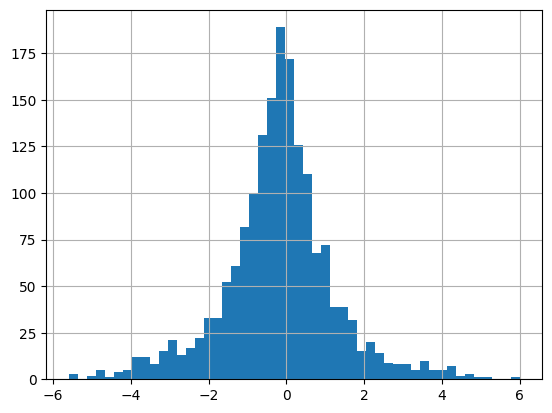

In [16]:
rb_df.loc[rb_df.yoy_ff_pct_change != 0]['yoy_ff_pct_change'].hist(bins=50)

In [17]:
rb_df.loc[rb_df.yoy_ff_pct_change != 0]['yoy_ff_pct_change'].describe()

count    1744.000000
mean       -0.187210
std         1.441919
min        -5.594711
25%        -0.860752
50%        -0.153083
75%         0.513696
max         5.993961
Name: yoy_ff_pct_change, dtype: float64